# Grid Size Experiment

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from commands.datastore import Datastore
from functools import reduce
from parse import parse
import numpy as np
from experiments.reversed_single_filter.experiment import ReversedSingleFilterExperiment
import tarfile
from experiments.grid_size.experiment import GridSizeExperiment
import matplotlib.ticker as ticker


sns.set_theme(context="paper", style="whitegrid", rc={"text.usetex" : False})
sns.set_palette("deep")
sns.color_palette("deep")
sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True,
})

data_store = Datastore().derive("reversed_single_filter")
figures = data_store / "figures"
figures.mkdir(exist_ok=True, parents=True)
solutions_df = None

In [3]:
import os
from pathlib import Path
debug = False

def create_df(path: str = data_store, tar_files = ["reversed_single_filter.tar"], best_solution=False) -> pd.DataFrame:
    path = Path(path)
    experiment_runs = set()
    for file in [path / tar for tar in tar_files]:
        with tarfile.open(file, "r:*") as tar:
            for f in tar.getnames():
                result = parse("{layer_name}_{i}_{j}_{row}_{col}/train_statistics/fitness/{file}", f)
                if result is not None:
                    experiment = "{layer_name}_{i}_{j}_{row}_{col}".format(**result.named)
                    csv = pd.read_csv(tar.extractfile(f))
                    csv["Grid"] = f'{result["row"]},{result["col"]}'
                    csv["Experiment"] = experiment
                    
                    occurence_string = experiment + "/" + result["file"]
                    
                    if occurence_string in experiment_runs:
                        csv["run"] = csv["run"] + 30
                    
                    experiment_runs.add(occurence_string)
                    if best_solution:
                        yield csv.tail(n=1)
                    else:
                        yield csv
                elif debug:
                    print(f"ignoring {f}")

def load_dfs(path: str = data_store, tar_files = ["reversed_single_filter.tar"], best_solution=False):
    df = pd.concat([df for df in create_df(path, tar_files, best_solution=best_solution)], ignore_index=True)
    df.drop(columns="depth", inplace=True, errors="ignore")
    df.drop_duplicates(subset=["generation"], inplace=True)
    df.columns = df.columns.str.title().str.replace("_", " ")
    return df

def get_best_solutions(df):
    best_solutions = []
    chromosomes_df: pd.DataFrame = df.dropna().sort_values(by=["Error", "Energy", "Delay", "Gate Count"], ascending=True)
    groups = chromosomes_df.groupby(by=["Experiment", "Run"])
    best_solutions = groups.apply(pd.DataFrame.head, n=1)
    return best_solutions  

fitness_columns = ["Error", "Energy", "Area", "Delay", "Gate Count"]
quantized_columns = ["Error", "Quantized Energy", "Quantized Delay"]


## Data Exploration Analysis

In [4]:
df.describe()

,Run,Generation,Timestamp,Error,Quantized Energy,Energy,Area,Quantized Delay,Delay,Gate Count
count,25969.000000,2.596900e+04,25969.000000,25969.000000,2.596900e+04,25969.000000,25969.000000,2.596900e+04,25969.000000,25969.000000
mean,15.416689,2.567014e+05,55.315277,24.661828,3.937804e+17,0.074177,321.615702,2.560801e+18,0.578795,13.996958
std,8.583395,6.425221e+05,170.686779,137.613014,9.889655e+17,0.105006,310.631258,2.473137e+18,0.446793,5.828517
min,1.000000,1.000000e+00,0.000064,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,4.000000
25%,8.000000,8.337000e+03,1.377745,0.000000,4.528956e+15,0.002911,96.206498,7.075463e+17,0.280000,10.000000
50%,15.000000,3.101800e+04,5.557094,0.000000,6.062722e+16,0.025585,200.391102,1.844674e+18,0.630000,13.000000
75%,23.000000,1.474400e+05,26.591875,0.000000,2.792843e+17,0.151784,481.501795,3.487193e+18,0.740000,16.000000
max,30.000000,8.567436e+06,2527.020048,10490.000000,1.384841e+19,1.108686,3257.411271,1.844674e+19,2.810000,47.000000


In [5]:
generation_df = df.copy()

runs = generation_df["Run"].unique()
grids = generation_df["Grid"].unique()
new_dfs = []
for grid in grids:
    for run in runs:
        run_df = generation_df.loc[(generation_df["Run"] == run) & (generation_df["Grid"] == grid), :]
        run_df["Generation Delta"] = run_df["Generation"].diff()
        
        for col in fitness_columns:
            if col != "Area":
                run_df[f"{col} Delta"] = run_df[col].diff()
            else:
                run_df[f"{col} Delta"] = run_df[col]
        run_df = run_df.iloc[1:]
        for col in fitness_columns:
            run_df[f"{col} Delta"] = run_df[f"{col} Delta"].apply(lambda x: x if x < 0 else 0)

        zero_deltas = [run_df[f"{col} Delta"] == 0 for col in fitness_columns]
        run_df = run_df.loc[~reduce(lambda a, b: a & b, zero_deltas), :]
        run_df["Run"] = run
        new_dfs.append(run_df)


dfs_delta = pd.concat(new_dfs)
epoch = int(dfs_delta["Generation Delta"].std())
for gen in range(0, dfs_delta["Generation"].max() + epoch, epoch):
    dfs_delta.loc[dfs_delta["Generation"].isin(range(gen, gen+epoch)), "Generation"] = gen


# dfs_delta.iloc[dfs_delta["generation_delta"].idxmax()]

C:\Users\Majo\AppData\Local\Temp\ipykernel_33492\3463333215.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df["Generation Delta"] = run_df["Generation"].diff()
C:\Users\Majo\AppData\Local\Temp\ipykernel_33492\3463333215.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df[f"{col} Delta"] = run_df[col].diff()
C:\Users\Majo\AppData\Local\Temp\ipykernel_33492\3463333215.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

<Figure size 640x480 with 0 Axes>

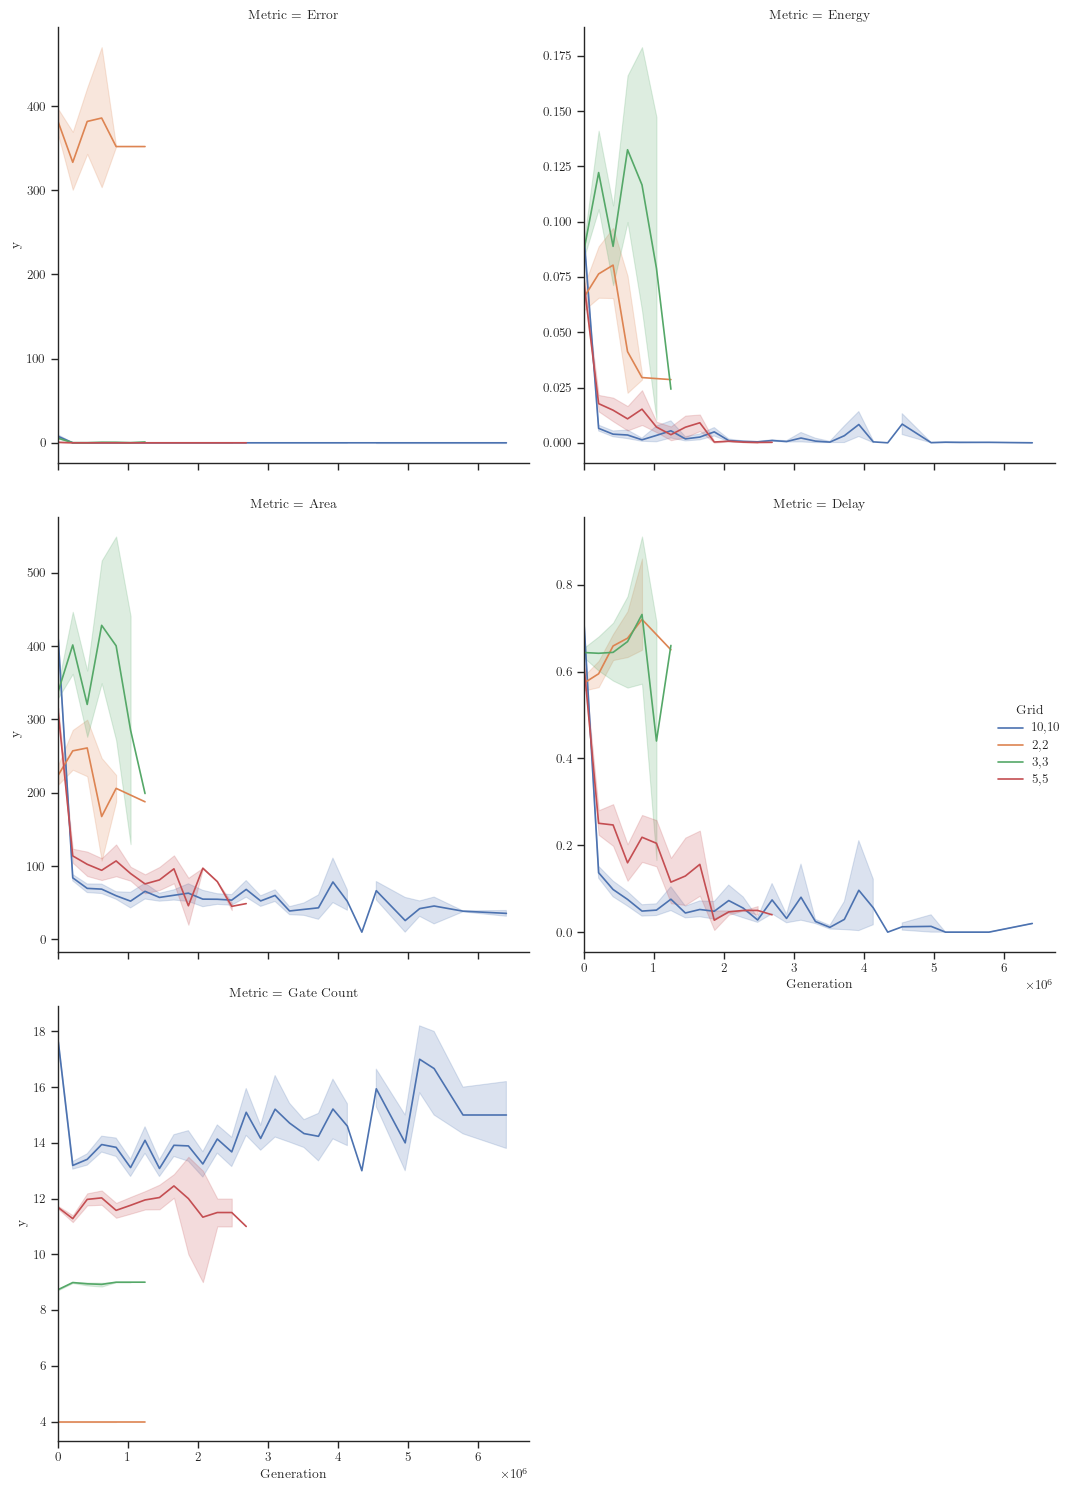

In [6]:
plot_df = pd.melt(dfs_delta, id_vars=["Generation", "Grid"], value_vars=fitness_columns, var_name="Metric", value_name="y")
# for col in relevant_columns:
#     g = sns.relplot(data=dfs_delta, x="Generation", y=col, hue="Grid", kind="line", facet_kws={"sharey": False, "sharex": True})
#     g.set(xlim=0)
#     sns.despine(left=False, bottom=False, offset=0)
#     plt.savefig(data_store / f"grid_size_evolution_{col}.png")
#     plt.savefig(data_store / f"grid_size_evolution_{col}.pdf")
#     plt.clf()

sns.despine(left=False, bottom=False, offset=0)
g = sns.relplot(data=plot_df, x="Generation", y="y", col="Metric", hue="Grid", kind="line", col_wrap=2, facet_kws={"sharey": False, "sharex": True})
g.set(xlim=0)

plt.tight_layout()

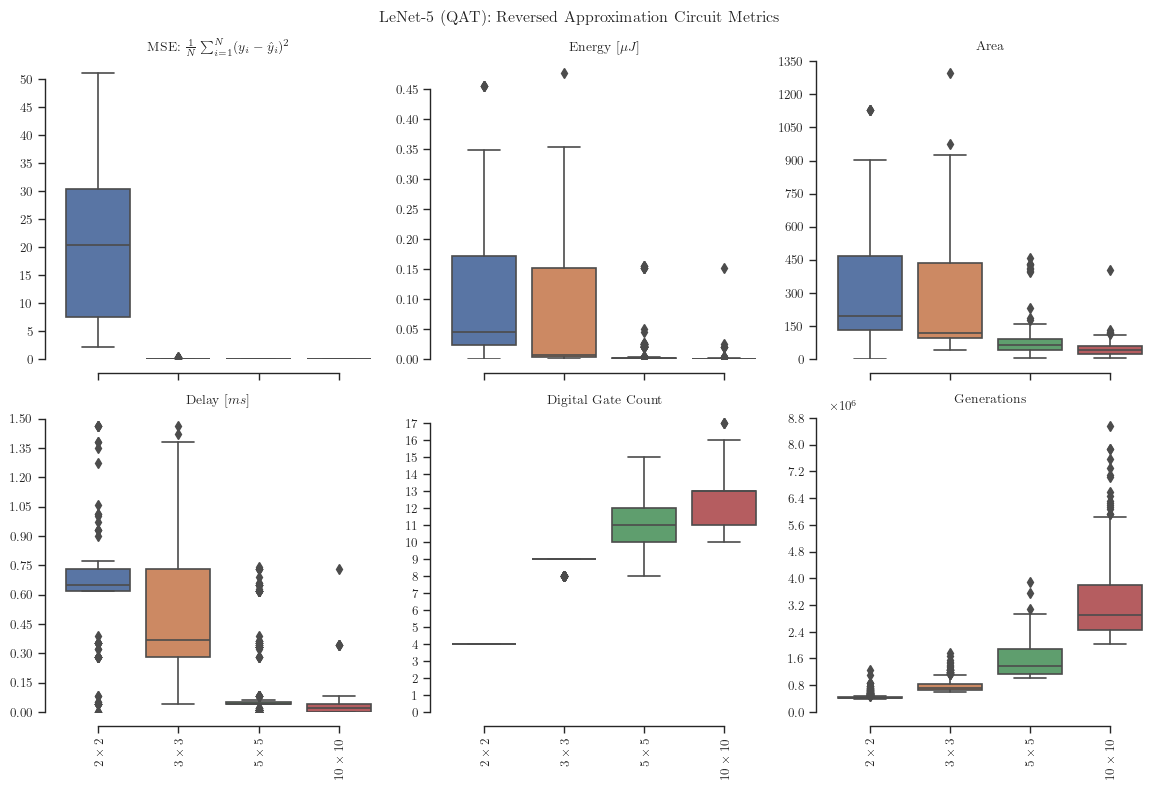

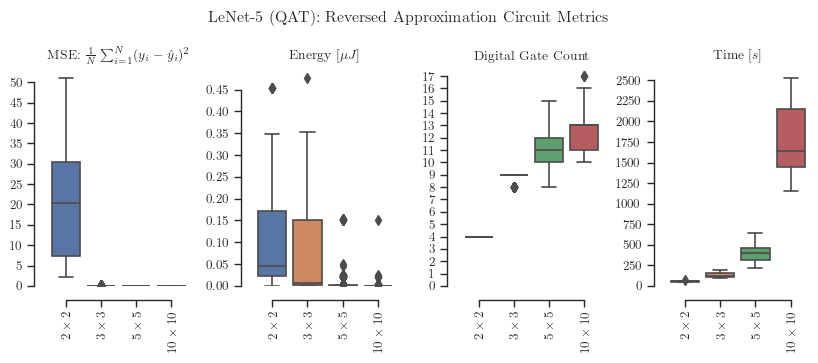

In [4]:
order=["2,2", "3,3", "5,5", "10,10"]
def load_df(tar_files = ["reversed_single_filter.tar"]):
    solutions_df = load_dfs(tar_files=tar_files, best_solution=True)
    solutions_df["Error"] = solutions_df["Error"] / 16
    return solutions_df

titles = {
    "Error": r"MSE: $\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$",
    "Energy": "Energy [$\mu J$]",
    "Area": "Area",
    "Delay": "Delay [$ms$]",
    "Gate Count": "Digital Gate Count",
    "Generation": "Generations",
    "Timestamp": "Time $[s]$"
}

def plot(solutions_df, col, ax, i, sharex_index=True, landscape=False):
    tick_count = (solutions_df["Gate Count"].max() + 1) // (2 if (col != "Gate Count") else 1)
    if col == "Timestamp":
        solutions_df = solutions_df.groupby(by=["Grid", "Run"])["Timestamp"].max().reset_index()        
    g = sns.boxplot(data=solutions_df, x="Grid", y=col, order=order, ax=ax)
    dimensions = [tuple(label.get_text().split(",")) for label in g.get_xticklabels()]
    g.yaxis.set_major_locator(plt.MaxNLocator(tick_count, min_n_ticks=10, integer=(col=="Gate Count")))
    g.set_ylim(0)
    g.set_title(titles[col])
    g.set_ylabel(None)
    g.set_xlabel(None)
    g.set_xticklabels([f"${x} \\times {y}$" for x, y in dimensions])
    g.tick_params(axis="x", rotation=90)
    if i < sharex_index:
        g.axes.get_xaxis().set_ticklabels([])
        g.set_xlabel(None)
    return g    

def plot_columns(df, columns, r, c, sharex=True, landscape=False):
    fig, axes = plt.subplots(r, c, figsize=(8.27 if not landscape else 11.69, 3.65 * r if not landscape else 8))
    for col, ax, i in zip(columns, axes.flat, range(r*c)):
        plot(df, col, ax, i, c if sharex else 0, landscape=landscape)    
    return fig


solutions_df = load_df()


fig_all = plot_columns(solutions_df, fitness_columns + ["Generation"], 2, 3, landscape=True)
fig_all.suptitle("LeNet-5 (QAT): Reversed Approximation Circuit Metrics")
sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_all)
fig_all.tight_layout()
fig_all.savefig(figures / "boxplot.png")
fig_all.savefig(figures / "boxplot.pdf")
fig_all.savefig(figures / "boxplot.svg")

fig_brief = plot_columns(solutions_df, ["Error", "Energy", "Gate Count", "Timestamp"], 1, 4, sharex=False)
fig_brief.suptitle("LeNet-5 (QAT): Reversed Approximation Circuit Metrics")
sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_brief)
fig_brief.tight_layout()
fig_brief.savefig(figures / "boxplot_brief.png")
fig_brief.savefig(figures / "boxplot_brief.pdf")
fig_brief.savefig(figures / "boxplot_brief.svg")


In [8]:
import scipy.stats as stats
import scikit_posthocs as sp

solutions_df = solutions_df if solutions_df is not None else load_dfs(best_solution=True)

def examine(df, grid1, grid2, variable, alternative="less"):
    sign = "<" if alternative == "less" else "!=" if alternative == "two-sided" else ">"
    group1 = df.loc[df["Grid"] == grid1, variable]
    group2 = df.loc[df["Grid"] == grid2, variable]
    levene_stat, levene_p = stats.levene(group1, group2)
    normal_a_stat = stats.normaltest(group1)
    normal_b_stat = stats.normaltest(group2)
    if normal_a_stat.pvalue >= 0.05 and normal_b_stat.pvalue >= 0.05:
        result = stats.ttest_ind(group1, group2, equal_var=levene_p>=0.5, alternative=alternative)
        test = "T-Test"
    else:
        result = stats.mannwhitneyu(group1, group2, alternative=alternative)
        test = "MWU"    
    print(f"Result: {'HA' if result.pvalue < 0.05 else 'H0'} , Hypotheses: H0: {variable}[{grid1}] == {variable}[{grid2}]; HA: {variable}[{grid1}] {sign} {variable}[{grid2}], samples = {len(group1.index)}: {test}, {result}")
    

order=["2,2", "3,3", "5,5", "10,10"]
# anova = stats.kruskal(*groups)
# print(stats.kruskal(*groups))

# if anova.pvalue < 0.5:
#     print(sp.posthoc_dunn(solutions_df, group_col="Grid", val_col=variable).to_latex())

time_df = solutions_df.groupby(by=["Grid", "Run"])["Timestamp"].max().reset_index()
examine(solutions_df, "10,10", "5,5", "Energy", alternative="greater")
examine(solutions_df, "10,10", "5,5", "Energy", alternative="two-sided")
examine(solutions_df, "10,10", "5,5", "Energy")
examine(time_df, "5,5", "10,10", "Timestamp")
examine(solutions_df, "5,5", "10,10", "Gate Count")

t1_mean = time_df.loc[time_df["Grid"] == "5,5", "Timestamp"].mean()
t2_mean = time_df.loc[time_df["Grid"] == "10,10", "Timestamp"].mean()
print(t2_mean / t1_mean)

print("H0: 10x10 gate count == 25; HA: 10x10 gate count < 25:", stats.ttest_1samp(solutions_df.loc[solutions_df["Grid"] == "10,10", "Gate Count"], 25, alternative="less"))


Result: H0 , Hypotheses: H0: Energy[10,10] == Energy[5,5]; HA: Energy[10,10] > Energy[5,5], samples = 360: MWU, MannwhitneyuResult(statistic=36645.0, pvalue=1.0)
Result: HA , Hypotheses: H0: Energy[10,10] == Energy[5,5]; HA: Energy[10,10] != Energy[5,5], samples = 360: MWU, MannwhitneyuResult(statistic=36645.0, pvalue=5.944742073032615e-24)
Result: HA , Hypotheses: H0: Energy[10,10] == Energy[5,5]; HA: Energy[10,10] < Energy[5,5], samples = 360: MWU, MannwhitneyuResult(statistic=36645.0, pvalue=2.9723710365163076e-24)
Result: HA , Hypotheses: H0: Timestamp[5,5] == Timestamp[10,10]; HA: Timestamp[5,5] < Timestamp[10,10], samples = 30: T-Test, TtestResult(statistic=-16.511247694412862, pvalue=2.2179360564357574e-17, df=31.549467731267256)
Result: HA , Hypotheses: H0: Gate Count[5,5] == Gate Count[10,10]; HA: Gate Count[5,5] < Gate Count[10,10], samples = 360: MWU, MannwhitneyuResult(statistic=32705.5, pvalue=6.021975884096557e-32)
4.444268074506861
H0: 10x10 gate count == 25; HA: 10x10 g